# Project 1: Gradient-based Algorithms and Differentiable Programming



## 1. Introduction

The given project's objective is demonstrated with the below mentioned formulation considering a simlpe case of optimizing the trajectory for a rocket landing.

Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$
where $\Delta t$ is a time interval. Further, let the closed-loop controller be

$$
a(t) = f_{\theta}(x(t))
$$
where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad &amp; ||x(T)||^2 \\
\quad  d(t+1) = d(t) + v(t) \Delta t, \\
\quad  v(t+1) = v(t) + a(t) \Delta t, \\
\quad  a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$
While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1)$ and $a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$.

In the following, we code this problem up with PyTorch, which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.



## 2. Problem formulation

### Description of chosen case

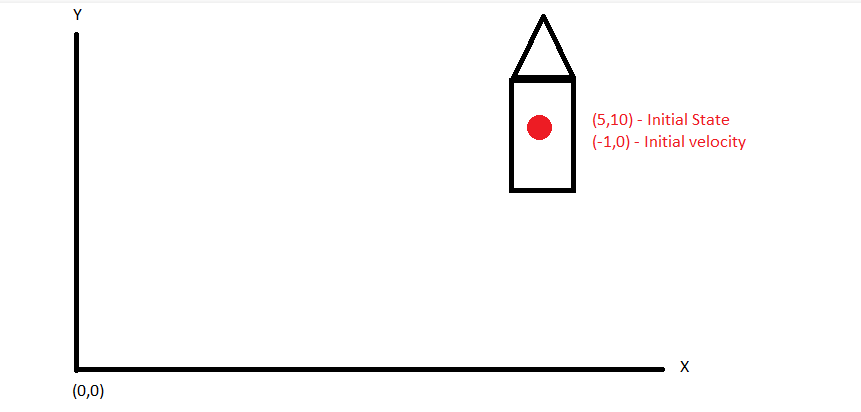

For my problem formulation, I have chosen a 2D scenario for rocket landing with the addition of drag force  causing decelaration in Y axis alone. The initial co-ordinates of the rocket are (5,10) with initial velocities V_x and V_y being (-1,0) respectively. The rocket has thrusters in both X and Y directions with the same thrust constant to control it's descent. 

The objective of this project is to land the rocket as close to the target landing site as possible with zero velocity at landing. For this, we have chosen our control parameters to be Y, V_y, X and V_x which will form our loss function.


### Objective Function
$$
\begin{aligned}
\quad\min_{\theta} ||s(T)||^2 
\end{aligned}
$$
where,$$
\begin{aligned}
\quad s(T) = (Y(T), V_y(T), X(T), V_x(T))
\end{aligned}
$$

### Variables

$S$: State,

$t$: Time,

$Y$: y coordinate,

$V_y$: Velocity in y direction,

$X$: x coordinate,

$V_x$: Velocity in x direction,

$a_y$: Acceleration in x direction,

$a_x$: Acceleration in x direction,

### Constraints

$$
\begin{aligned}
\\ \quad  Y(t+1) = Y(t) + V_y(t) \Delta t, \\
\\ \quad  V_y(t+1) = V_y(t) + a_y(t) \Delta t - a_ydrag(t) \Delta t, \\
\\ \quad  X(t+1) = X(t) + V_x(t) \Delta t, \\
\\ \quad  V_x(t+1) = V_x(t) + a_x(t) \Delta t, \\
\\ \quad  a_y(t),a_x(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

### Assumptions

For the case of Drag, the rocket is assumed to be falcon 9 with the following assumptions being made for it's input parameters

    Drag force: D = Cd * A * .5 * r * V^2
    Rocket in assumption is falcon 9
    Cd = 0.25 (Drag co-efficint of long cyclinder with a cone nose) 
    ref: https://space.stackexchange.com/questions/16883/whats-the-atmospheric-drag-coefficient-of-a-falcon-9-at-launch-sub-sonic-larg
    A = pi * 12 feet ^2 (Diameter of falcon 9) = 34 m^2
    r = 850 kg/m^3 (Density of steel)
    V = velocity = delta state
    m = 549054 Kg (Mass of falcon 9)
        
    D = 0.25 * 34 * 0.5 * 850 * delta_state**2
    
    also applying force balance on the rocket
    
    m * DRAG_DECEL (deceleration due to drag) = D
    DRAG_DECEL = 0.00658 * delta_state**2

After calculating the drag force, the rocket is assumed to be a point mass and only it's only it's movement is controlled.


## 2. Programming

In [4]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [5]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 9.8  # gravity constant g = 9.8 m/s^2
BOOST_ACCEL = 15  # assuming thrust constant to be 15 m/s^2 as it ususally more than g 

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [12]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action[0] = Thrust in y
        action[1] = Thrust in x
        state[0] = y
        state[1] = y_dot
        state[2] = x
        state[3] = x_dot
        """
       
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.]) #Converting to 2D

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0] #Converting to 2D in y
        
        delta_state_x = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1.]) * action[1]  # converting to 2D in x
        
        temp = delta_state_y
        
        """"
        The following is the cacluctions and assumptions made to incorporate the drag effect in our rocket landing model
        
        Drag force: D = Cd * A * .5 * r * V^2
        Rocket in assumption is falcon 9
        Cd = 0.25 (Drag co-efficint of long cyclinder with a cone nose) ref: https://space.stackexchange.com/questions/16883/whats-the-atmospheric-drag-coefficient-of-a-falcon-9-at-launch-sub-sonic-larg
        A = pi * 12 feet ^2 (Diameter of falcon 9) = 34 m^2
        r = 850 kg/m^3 (Density of steel)
        V = velocity = delta state
        m = 549054 Kg (Mass of falcon 9)
        
        D = 0.25 * 34 * 0.5 * 850 * delta_state**2
        
        also applying force balance on the rocket
        
        m * DRAG_DECEL (deceleration due to drag) = D
        DRAG_DECEL = 0.00658 * delta_state**2
        
        """
        #Updating drag
        DRAG_DECEL = 0.00658 * temp* temp
        
        NET_ACCEL = BOOST_ACCEL - DRAG_DECEL # Updating net accel in Y
        
        #Re-calculating new velocity in Y
        delta_state_y = NET_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0]

        # Update velocity
        state = state + delta_state_y + delta_state_gravity + delta_state_x
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [13]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),#added new layer
            nn.Linear(dim_hidden, dim_hidden),#added new layer
            nn.Tanh(),#added new layer
            nn.Tanh(),#added a new layer
            nn.Linear(dim_hidden, dim_output),#added new hidden layer
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [37]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        #Rocket is coming down from a height of 10 m with 0 m/s initial velocity in Y
        #Rocket is 5 m to the right of target landing side with -1 m/s initial velocity in X
        state = [10., 0., 5., -1.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

In [38]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('_______________________________________________________________________________________________________________')
            print('\nIteration number:\t',epoch+1)
            print('loss: %.3f' % (loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        a = data[:, 2]
        b = data[:, 3]
        
        plt.figure()
        plt.subplot(221)
        plt.title('Distance_Y vs velocity_Y plot')
        plt.xlabel('Distance_Y')
        plt.ylabel('Velocity_Y')
        plt.plot(x, y)
        
        plt.subplot(222)
        plt.title('Distance_X vs velocity_X plot')
        plt.xlabel('Distance_X')
        plt.ylabel('Velocity_X')
        plt.plot(a, b)
        plt.tight_layout()
        plt.show()

_______________________________________________________________________________________________________________

Iteration number:	 1
loss: 67819.812


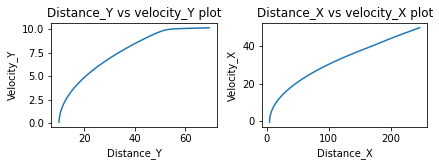

_______________________________________________________________________________________________________________

Iteration number:	 2
loss: 40903.543


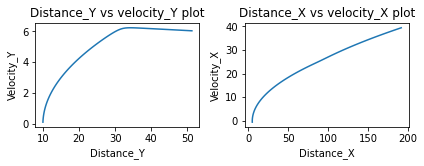

_______________________________________________________________________________________________________________

Iteration number:	 3
loss: 24353.953


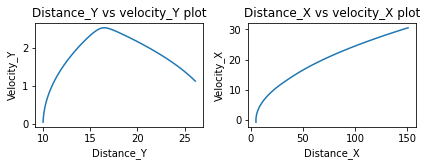

_______________________________________________________________________________________________________________

Iteration number:	 4
loss: 16562.732


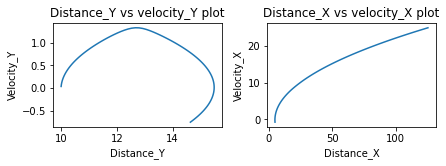

_______________________________________________________________________________________________________________

Iteration number:	 5
loss: 8962.082


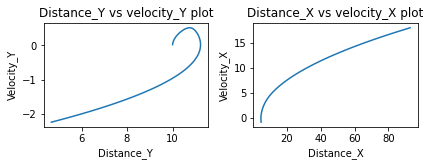

_______________________________________________________________________________________________________________

Iteration number:	 6
loss: 4479.857


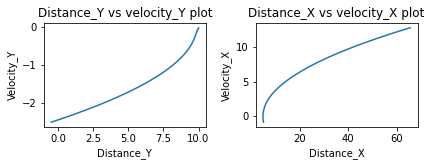

_______________________________________________________________________________________________________________

Iteration number:	 7
loss: 3104.110


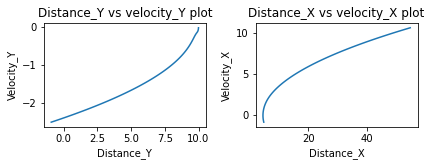

_______________________________________________________________________________________________________________

Iteration number:	 8
loss: 2153.657


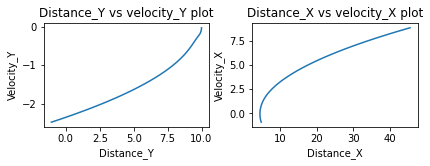

_______________________________________________________________________________________________________________

Iteration number:	 9
loss: 1600.859


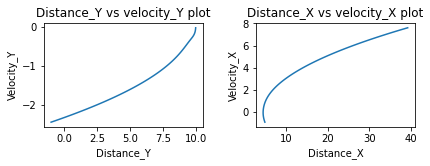

_______________________________________________________________________________________________________________

Iteration number:	 10
loss: 1225.448


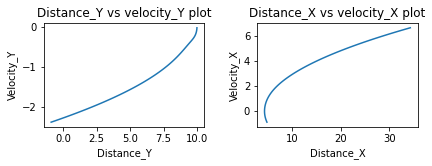

_______________________________________________________________________________________________________________

Iteration number:	 11
loss: 948.045


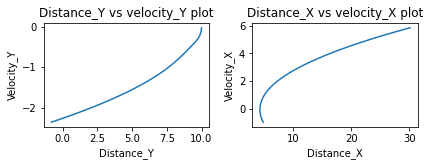

_______________________________________________________________________________________________________________

Iteration number:	 12
loss: 734.276


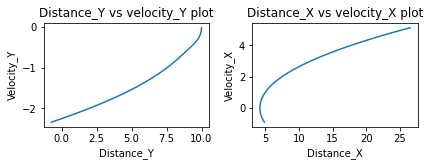

_______________________________________________________________________________________________________________

Iteration number:	 13
loss: 555.420


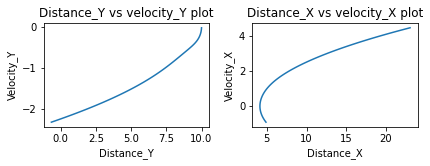

_______________________________________________________________________________________________________________

Iteration number:	 14
loss: 282.957


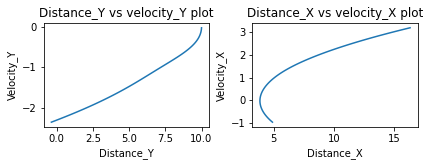

_______________________________________________________________________________________________________________

Iteration number:	 15
loss: 173.724


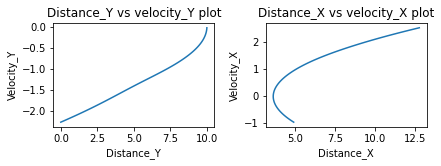

_______________________________________________________________________________________________________________

Iteration number:	 16
loss: 127.821


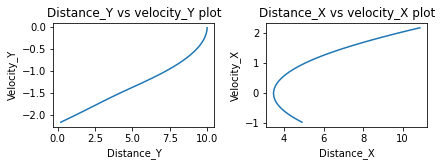

_______________________________________________________________________________________________________________

Iteration number:	 17
loss: 95.653


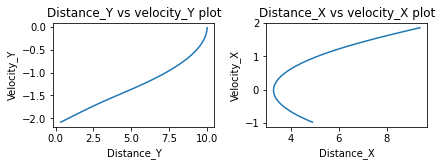

_______________________________________________________________________________________________________________

Iteration number:	 18
loss: 59.163


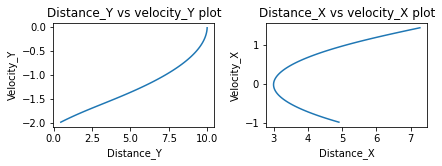

_______________________________________________________________________________________________________________

Iteration number:	 19
loss: 30.396


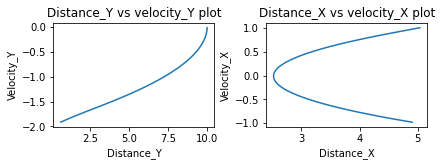

_______________________________________________________________________________________________________________

Iteration number:	 20
loss: 19.290


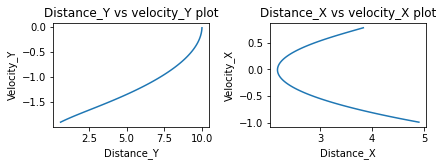

_______________________________________________________________________________________________________________

Iteration number:	 21
loss: 13.601


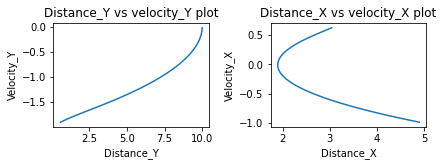

_______________________________________________________________________________________________________________

Iteration number:	 22
loss: 10.167


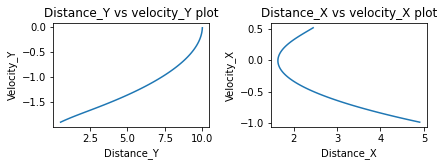

_______________________________________________________________________________________________________________

Iteration number:	 23
loss: 7.768


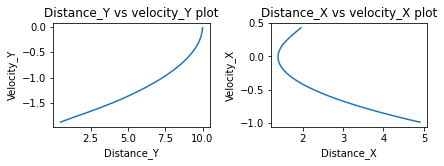

_______________________________________________________________________________________________________________

Iteration number:	 24
loss: 5.586


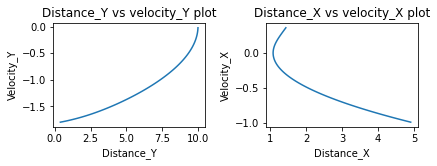

_______________________________________________________________________________________________________________

Iteration number:	 25
loss: 1.652


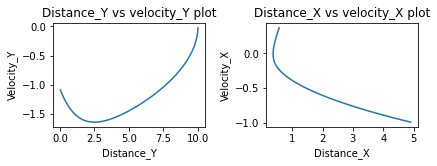

_______________________________________________________________________________________________________________

Iteration number:	 26
loss: 1.146


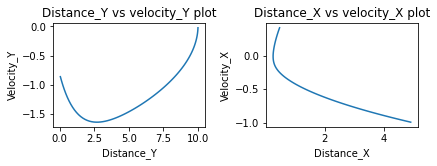

_______________________________________________________________________________________________________________

Iteration number:	 27
loss: 0.897


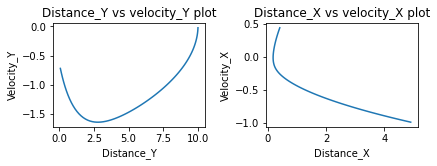

_______________________________________________________________________________________________________________

Iteration number:	 28
loss: 0.745


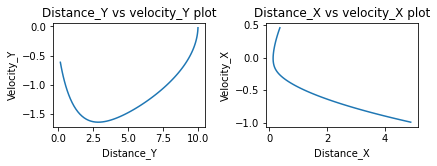

_______________________________________________________________________________________________________________

Iteration number:	 29
loss: 0.642


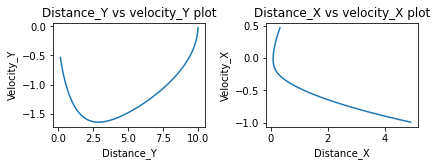

_______________________________________________________________________________________________________________

Iteration number:	 30
loss: 0.564


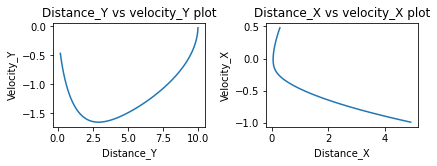

_______________________________________________________________________________________________________________

Iteration number:	 31
loss: 0.481


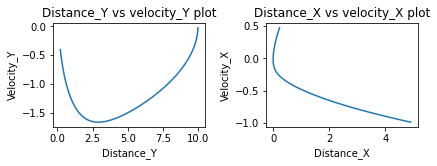

_______________________________________________________________________________________________________________

Iteration number:	 32
loss: 0.390


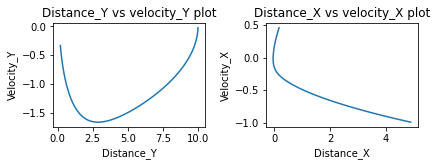

_______________________________________________________________________________________________________________

Iteration number:	 33
loss: 0.304


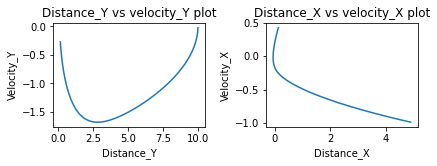

_______________________________________________________________________________________________________________

Iteration number:	 34
loss: 0.233


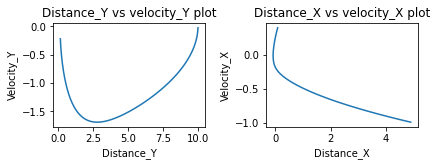

_______________________________________________________________________________________________________________

Iteration number:	 35
loss: 0.175


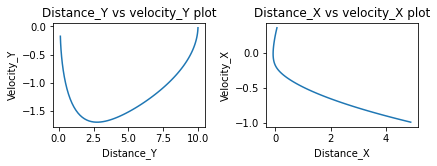

_______________________________________________________________________________________________________________

Iteration number:	 36
loss: 0.130


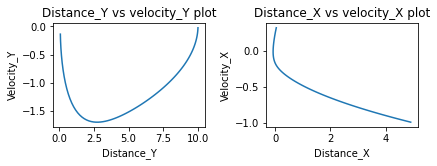

_______________________________________________________________________________________________________________

Iteration number:	 37
loss: 0.093


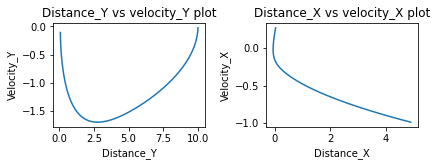

_______________________________________________________________________________________________________________

Iteration number:	 38
loss: 0.065


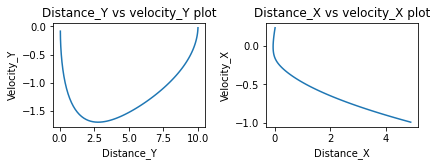

_______________________________________________________________________________________________________________

Iteration number:	 39
loss: 0.045


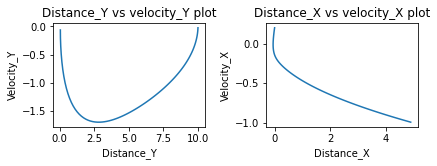

_______________________________________________________________________________________________________________

Iteration number:	 40
loss: 0.031


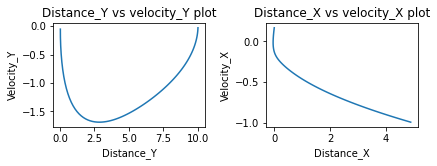

_______________________________________________________________________________________________________________

Iteration number:	 41
loss: 0.022


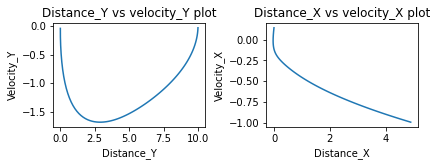

_______________________________________________________________________________________________________________

Iteration number:	 42
loss: 0.015


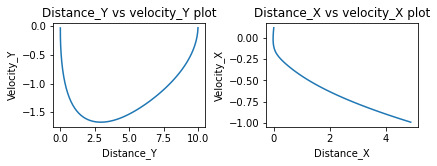

_______________________________________________________________________________________________________________

Iteration number:	 43
loss: 0.010


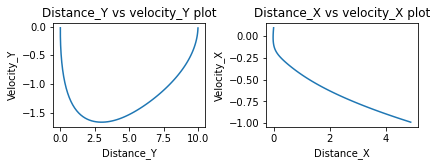

_______________________________________________________________________________________________________________

Iteration number:	 44
loss: 0.007


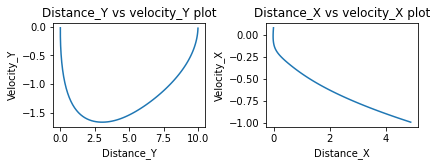

_______________________________________________________________________________________________________________

Iteration number:	 45
loss: 0.005


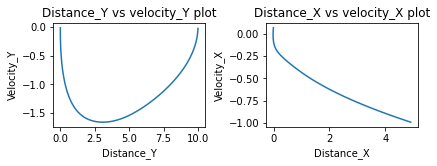

_______________________________________________________________________________________________________________

Iteration number:	 46
loss: 0.003


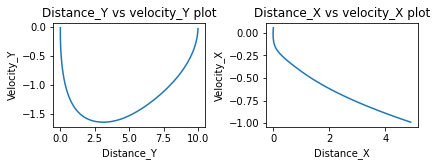

_______________________________________________________________________________________________________________

Iteration number:	 47
loss: 0.002


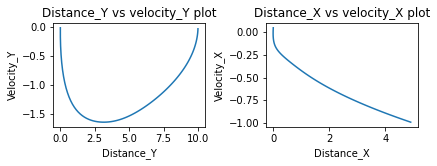

_______________________________________________________________________________________________________________

Iteration number:	 48
loss: 0.002


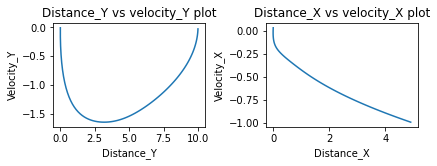

_______________________________________________________________________________________________________________

Iteration number:	 49
loss: 0.001


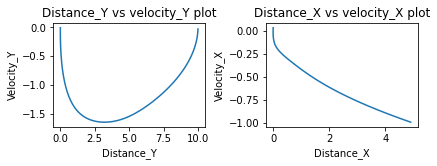

_______________________________________________________________________________________________________________

Iteration number:	 50
loss: 0.001


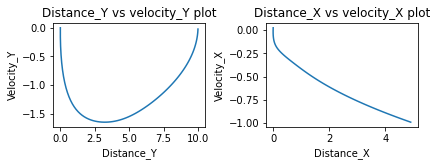

_______________________________________________________________________________________________________________

Iteration number:	 51
loss: 0.000


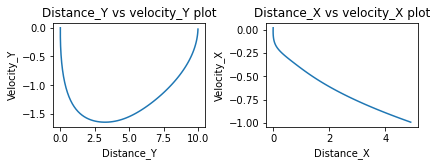

_______________________________________________________________________________________________________________

Iteration number:	 52
loss: 0.000


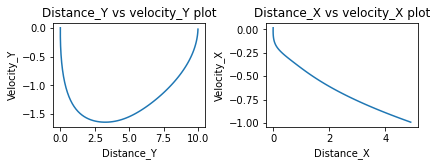

_______________________________________________________________________________________________________________

Iteration number:	 53
loss: 0.000


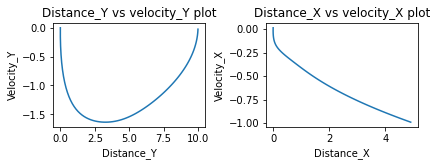

_______________________________________________________________________________________________________________

Iteration number:	 54
loss: 0.000


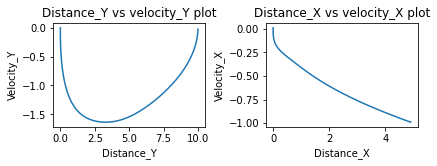

_______________________________________________________________________________________________________________

Iteration number:	 55
loss: 0.000


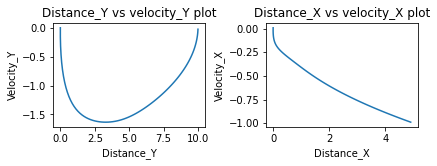

_______________________________________________________________________________________________________________

Iteration number:	 56
loss: 0.000


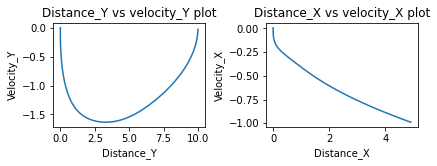

_______________________________________________________________________________________________________________

Iteration number:	 57
loss: 0.000


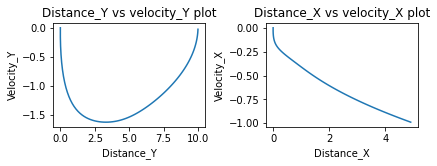

_______________________________________________________________________________________________________________

Iteration number:	 58
loss: 0.000


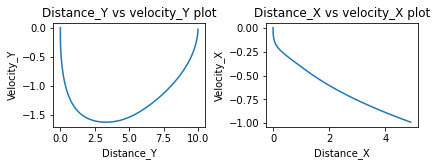

_______________________________________________________________________________________________________________

Iteration number:	 59
loss: 0.000


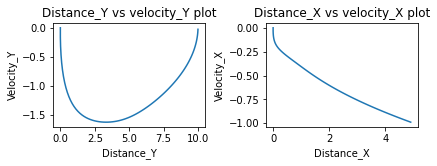

_______________________________________________________________________________________________________________

Iteration number:	 60
loss: 0.000


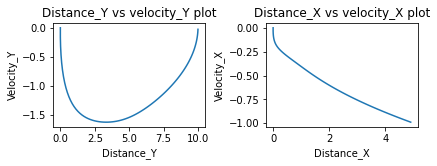

In [39]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4  # state space dimensions (y, y_dot, x, x_dot)
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions (a_y, a_x)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(60)  # solve the optimization problem

## 3. Analysis of the results

We can see the Distance Vs. Velocity plot for the rocket landing for both, X and Y direction after every iteration along with it's corresponding loss function value. 

As evident, the result is achieved within 52 iterations by the neural network and the enitre code is run for 60 iterations.

1. In the 1st iteration, We have a very high loss of about ~ 67800 which is the highest recorded loss indicating that the rocket has not landed as per requirement or even in the right location as per the graph.

2. After the 4th iteration, there is a drastic change in the graph indicating that the neural network might be trying a different approach.

3. By iteration number 27, the loss has reduced to around ~1 marking a reduction of around 99% in loss as compared to the 1st iteration.

4. By 44th iteration, the loss is less than < 0.01 and the rocket is able to land at the correct position but with some value for velocity.

5. At 51st iteration and onwards, we have achieved loss = 0 and thus, our objective function has been properly minimized and the target landing conditions are satisfied. Thus, we can say that with the currently formulated neural network and dynamic model, we are able to achieve convergence and minimize our objective function in around 50 iterations each with a time step of 0.1 seconds. 

6. The "V vs distance" plots for both X and Y shows the change in velocity with distance when looked from the right to the left. 

